### Setup

In [1]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install tensorflow --quiet
!pip install sklearn --quiet
!pip install tensorflow-addons --quiet
!pip install germansentiment --quiet
!pip install transformers[sentencepiece] --quiet
!pip install wandb --quiet
!pip install optuna --quiet

In [2]:
from datasets import Dataset, DatasetDict
import os
import optuna
import wandb
from wandb.integration.keras import WandbCallback
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification,
    AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, create_optimizer, pipeline
from germansentiment import SentimentModel
import torch
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils.utils import get_project_root
from datasets import load_metric
import matplotlib.pyplot as plt
from pathlib import Path

### Create test lists

Zuerst laden wir alle notwendigen Daten in pandas dataframes.

Unsere Daten bestehen aus einem manuell gesammelten und gelabelten Datensatz von 105 Nachrichtenartikeln, jeweils mit Titel und body-text. Dieser Datensatz wird als Testset verwendet und stellt unsere Ziel-Verteilung dar.

Um trotzdem ein Modell finetunen zu können, verwenden wir zusätzlich einen weiteren Datensatz: [financial news dataset von ankur Sinha](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news). 

Dieser beinhaltet 4837 Titel wovon 59% neutral sind, 28% positiv und 12% negativ. Leider beinhaltet er keine body-texte oder andere längere Textpassagen.

In [4]:
# import test data
df = pd.read_csv(get_project_root() / "content" / "data" / 'df_wirtschaft_labeled_en.csv')
df_financial_news = pd.read_csv(get_project_root() / "content" / "data" / 'financial-news-data.csv',
                                encoding="ISO-8859-1")
# import training data from csv
df_financial_news
# turn string labels into integer labels
df_financial_news["label"] = df_financial_news["label"].str.replace("negative", "0").str.replace("neutral",
                                                                                                 "1").str.replace(
    "positive", "2").astype(int)
df_financial_news.head(3)
df.head(3)

,Unnamed: 0,title,label_title,body,label_body,body_512,title_en,bodies_512_en
0,0,Corona-Gutscheine können bald eingelöst werden,1,Für abgesagte oder verschobene Konzerte und Re...,-1,Für abgesagte oder verschobene Konzerte und Re...,Corona vouchers can be redeemed soon,For cancelled or postponed concerts and trips ...
1,1,Strom und Gas: Grundversorger müssen Billiganb...,-1,Auf einen Schlag 20.000 neue Gaskunden: Weil B...,-1,Auf einen Schlag 20.000 neue Gaskunden: Weil B...,Electricity and gas: basic suppliers need to h...,"In a nutshell, 20,000 new gas customers: Becau..."
2,2,Atomenergie: Deutschland protestiert gegen EU-...,0,"Nur in Deutschland, Österreich und Luxemburg h...",-1,"Nur in Deutschland, Österreich und Luxemburg h...",Nuclear energy: Germany protests against EU pr...,"Only in Germany, Austria and Luxembourg has th..."
3,3,Auf Firmen und Verbraucher kommt noch mehr Inf...,-1,In den gestressten Unternehmen stauen sich wei...,-1,In den gestressten Unternehmen stauen sich wei...,Firms and consumers face even more inflation,"In the stressed companies, further price incre..."
4,4,Rückruf von 850.000 Autos: Mercedes warnt vor ...,-1,Mercedes ruft Hunderttausende Diesel zurück in...,-1,Mercedes ruft Hunderttausende Diesel zurück in...,"Callback of 850,000 cars: Mercedes warns again...",Mercedes calls hundreds of thousands of diesel...


In beiden Datensätzen sind die label nicht gleichverteilt. Um ein stabiles Model zu entwicklen, werden wir dies beim Training berücksichtigen.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9594809e50>]],
      dtype=object)

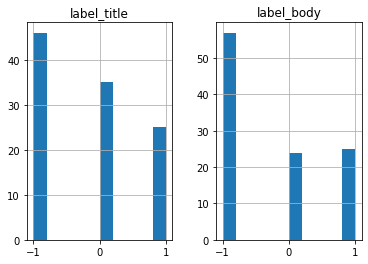

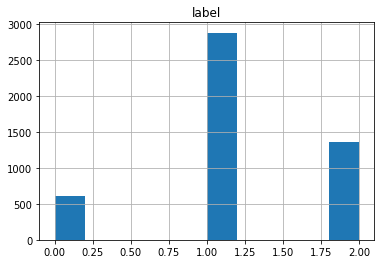

In [136]:
df.hist(column=["label_title", "label_body"])
df_financial_news.hist(column=["label", "headline"])

BERT erlaubt als Input maximal 512 Token. Der body-text ist jedoch oftmals länger. Wir teilen deshalb die Texte jeweils bei 512 Charaktern. Dies ist nur eine Annäherung, da die Tokenlänge nicht exact der Textlänge entspricht. Überstehende Buchstaben werden automatisch von Huggingface abgeschnitten und ignoriert.

In [6]:
# create test lists for title and body
input_titles_raw = [x for x in df["title"]]
input_bodies_raw = [x for x in df["body_512"]]
print(input_titles_raw[:3])
print(input_bodies_raw[:3])

['Corona-Gutscheine können bald eingelöst werden', 'Strom und Gas: Grundversorger müssen Billiganbietern aushelfen', 'Atomenergie: Deutschland protestiert gegen EU-Vorschlag']
['Für abgesagte oder verschobene Konzerte und Reisen gab es Gutscheine während der Corona-Pandemie. Bald kann man sich das Geld auszahlen lassen. Doch manche könnten auch leer ausgehen. Wir beantworten die wichtigsten Fragen.Manch einer dürfte in den beiden Jahren, die die Corona-Pandemie nun schon andauert, den Überblick verloren haben über die vielen verpassten Gelegenheiten. Immer wieder mussten und müssen Konzerte, Fußballspiele, Fitnesstrainings und Reisen abgesagt oder verschoben werden, mitunter sogar ', 'Auf einen Schlag 20.000 neue Gaskunden: Weil Billiganbieter nicht liefern können, müssen Grundversorger tausende Neukunden mitversorgen. Jetzt denken sie über höhere Preise für die Gestrandeten nach.Erst Grünwelt, dann Gas.de, am Montag Neckermann Strom, am Dienstag Stromio ? die Liste der bundesweit täti

Dann werden die deutschen texte ins englische übersetzt, um später englische pretrained models ausprobieren zu können.

In [31]:
# helsinki-nlp opus
if "title_en" not in df:
    model_checkpoint = "Helsinki-NLP/opus-mt-de-en"
    translator = pipeline("translation", model=model_checkpoint)
    %time input_titles_en_raw =[x["translation_text"] for x in translator(input_titles_raw)]
    %time input_bodies_en_raw =[x["translation_text"] for x in translator(input_bodies_raw)]
    df["title_en"] = input_titles_en_raw
    df["bodies_512_en"] = input_bodies_en_raw
    df.to_csv("df_wirtschaft_labeled_en.csv")
else:
    input_titles_en_raw = [x for x in df["title_en"]]
    input_bodies_en_raw = [x for x in df["bodies_512_en"]]

### Fine tuning english BERT on financial news

#### Creating the dataset

Jetzt wird der trainings- und validierungsdatensatz vorbereitet indem:
- der Datensatz in training und validation geteilt.
- mit sklearn die Gewichtungen der Klassen bestimmt.
- der Datensatz mit der `tokenize_function` in tokens umgewandelt.
- mit dem dataCollator Padding hinzugefügt, damit alle strings gleich lang sind.
- der Datensatz aus arrow in TensorFlow Datasets umgewandelt

In [9]:
# create arrow dataset from pandas
dataset = Dataset.from_pandas(df_financial_news)
# split arrow dataset into training and validation 
dataset_split = dataset.train_test_split(test_size=0.1)
train_data = dataset_split['train']
validation_data = dataset_split['test']
# create dataset dict which holds both datasets and allows map() to run on both
dataset = DatasetDict({
    'train': train_data,
    'validation': validation_data
})
# use sklearn to calculate classweights from dataset
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                                classes=np.unique(df_financial_news['label']),
                                                                y=df_financial_news['label'])
class_weights = dict(enumerate(class_weights))
print("class_weights:", class_weights)

# tokenize arrow dataset-dict using the map function
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(dat):
    return tokenizer(dat["headline"], truncation=True)


dataset_t = dataset.map(tokenize_function, batched=True)
# create padding function 
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

# generate TF datasets from arrow dataset dict and pass the padding function,
tf_train_dataset = dataset_t["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = dataset_t["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],  # necessary when label_col != labels?
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)
y_true = validation_data["label"]

class_weights: {0: 2.6743929359823397, 1: 0.5610744471459997, 2: 1.1851308388359012}


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### defining and training the model

Als nächstes kann das Model trainiert werden. Wir verwenden hierfür erstmal konservative Werte für die hyperparameter und werden danach mit optuna den hyperparameter raum nochmal absuchen.

Das model wird kompiliert und trainiert. Am Ende können wir die validation results mit der metric funktion von huggingface auswerten.

In [ ]:
# define training parameters and model
batch_size = 16
num_epochs = 3
initial_lr = 2e-5
batches_per_epoch = len(tf_train_dataset)
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=initial_lr, num_train_steps=total_train_steps, num_warmup_steps=0)
metrics = ["sparse_categorical_accuracy"]
# define model
checkpoint = 'distilbert-base-uncased'
model_distilbert_trained = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model_distilbert_trained.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=metrics
)

In [11]:
name_model = 'Distilbert'
model_distilbert_trained.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    class_weight=class_weights,
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath=f"/content/optuna/test",
        monitor="val_sparse_categorical_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,  # we can't store the entire model bc of huggingface
        verbose=False
    )]
)
dir = os.path.join(os.getcwd(), 'checkpoints_distilbert', f"model_best_lr_{initial_lr}")
model_distilbert_trained.save_pretrained(dir)
y_pred = np.argmax(model_distilbert_trained.predict(tf_validation_dataset)["logits"], axis=1)
# define validation metric - use f1-micro as score due to class-imbalances
metric_val = load_metric("f1")
validation_result = metric_val.compute(predictions=y_pred, references=y_true, average="micro")
validation_result

Epoch 1/3
272/272 [==============================] - 104s 270ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.4187 - val_sparse_categorical_accuracy: 0.8433
Epoch 2/3
272/272 [==============================] - 70s 258ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.3415 - val_sparse_categorical_accuracy: 0.8557
Epoch 3/3
272/272 [==============================] - 72s 267ms/step - loss: 0.2025 - sparse_categorical_accuracy: 0.9120 - val_loss: 0.3321 - val_sparse_categorical_accuracy: 0.8598


{'f1': 0.8597938144329897}

#### Training the model with optuna

Mit optuna lassen sich durch baysian optimization gezielt hyperparameter suchen. Der Algorithmus versucht anhand von vorherigen Versuchen die Auswahl zu verbessern und ist damit schneller als random oder grid-search.

Wir suchen die besten hyperparameter für:
- \# epochs
- learning rate
- weight decay der learning rate

Die besten Durchläufe werden mittels Keras-Callbacks wieder gespeichert, sodass wir später den besten Durchlauf laden können.

In [137]:
result_output_global = None


def objective_fn(trial):
    model_optuna = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    epochs = trial.suggest_int('num_train_epochs', low=2, high=7),
    learning_rate = trial.suggest_loguniform('learning_rate', low=4e-5, high=0.01)
    weight_decay = trial.suggest_loguniform('weight_decay', 4e-5, 0.01)
    batches_per_epoch = len(tf_train_dataset)
    total_train_steps = int(batches_per_epoch * num_epochs)
    optimizer, schedule = create_optimizer(
        init_lr=initial_lr,
        num_train_steps=total_train_steps,
        num_warmup_steps=0,
        weight_decay_rate=weight_decay
    )
    model_optuna.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=metrics
    )
    file_path = Path(f"/content/optuna/{trial.number}")
    file_path.mkdir(parents=True, exist_ok=True)
    result = model_optuna.fit(
        tf_train_dataset,
        validation_data=tf_validation_dataset,
        class_weight=class_weights,
        callbacks=[keras.callbacks.ModelCheckpoint(
            filepath=file_path,
            monitor="val_sparse_categorical_accuracy",
            mode="max",
            save_best_only=True,
            verbose=False
        )]
    )
    metric_val = load_metric("f1")
    y_pred = np.argmax(model_optuna.predict(tf_validation_dataset)["logits"], axis=1)
    return metric_val.compute(predictions=y_pred, references=y_true, average="micro")["f1"]


study = optuna.create_study(study_name="distilbert_optuna", direction="maximize")

[I 2022-02-22 14:37:31,362] A new study created in memory with name: distilbert_optuna


In [ ]:
# will raise warnings about skipping full serialization of keras layers, 
# probably due to huggingface's distilbert layers. We can ignore these though.
study.optimize(func=objective_fn, n_trials=15)

Nachdem die trials beendet sind, können wir uns die besten Ergebnisse ausgeben lassen und das model laden

In [149]:
print(study.best_params)
print(study.best_trial)
model_optuna = model_distilbert_trained
model_optuna.load_weights(f"optuna/{study.best_trial.number}")

{'num_train_epochs': 6, 'learning_rate': 0.008035124239202867, 'weight_decay': 8.324395731900464e-05}
FrozenTrial(number=7, values=[0.8556701030927835], datetime_start=datetime.datetime(2022, 2, 22, 14, 54, 49, 758787), datetime_complete=datetime.datetime(2022, 2, 22, 14, 56, 51, 232998), params={'num_train_epochs': 6, 'learning_rate': 0.008035124239202867, 'weight_decay': 8.324395731900464e-05}, distributions={'num_train_epochs': IntUniformDistribution(high=7, low=2, step=1), 'learning_rate': LogUniformDistribution(high=0.01, low=4e-05), 'weight_decay': LogUniformDistribution(high=0.01, low=4e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE, value=None)


### Testing BERT models from huggingface

Huggingface stellt in seiner Model-Library eine Vielzahl von Modellen bereit. Leider haben wir nur ein sehr kleines Test-Set, auf dem wir nur die Ergebnisse prüfen, aber das Modell nicht fine-tunen können. Dies versuchen wir im folgenden mit verschiedenen Modellen:

- [German sentiment Bert](https://huggingface.co/oliverguhr/german-sentiment-bert) von Oliver Guhr
- [German Sentiment Bert](https://huggingface.co/mdraw/german-news-sentiment-bert) auf Basis von Oliver Guhr, mit pretraining auf migrations-artikeln von mdraw.
-[ein multilingual bert model](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment) von NLPtown
- [ein weiteres German bert model von deepset](https://huggingface.co/deepset/bert-base-german-cased-sentiment-Germeval17), trainiert auf Germeval17
- Ein [Roberta-large-english](https://huggingface.co/j-hartmann/sentiment-roberta-large-english-3-classes) Modell von J. Hartmann, das wir auf den von [helsinki-nlp opus](https://huggingface.co/Helsinki-NLP/opus-mt-en-de) übersetzten Texten des Test-sets ausführen.
- Das [grundmodell (zero shot) von distilbert](https://huggingface.co/distilbert-base-uncased) von huggingface
- Das trainierte distilbert Modell von uns, das auf dem news-sentiment datensatz trainiert wurde. Wir versuchen hier die Erkennung in englisch und deutsch, auch wenn das Modell  kein deutsch verstehen sollte. Wir können so vergleichen, ob das trainierte modell (im englischen) etwas gelernt hat.
- Das mit optuna trainierte distilbert Modell (die beste Variante)

Oliver Guhr hat sein Modell und die features in einem extra-repository eingebettet, das wir hier verwenden und mit `SentimentModel()` aufrufen.
Unsere Label müssen wir für dieses Modell anpassen, da es die label als string ausgibt. 

In [13]:
# german-sentiment-bert
# https://huggingface.co/oliverguhr/german-sentiment-bert
model_ger_bert = SentimentModel()
%time df["gsb_title"] = model_ger_bert.predict_sentiment(input_titles_raw)
%time df["gsb_body"]  = model_ger_bert.predict_sentiment(input_bodies_raw)
df["gsb_title"] = df["gsb_title"].str.replace("negative", "-1").str.replace("neutral", "0").str.replace("positive",
                                                                                                        "1").astype(int)
df["gsb_body"] = df["gsb_body"].str.replace("negative", "-1").str.replace("neutral", "0").str.replace("positive",
                                                                                                      "1").astype(int)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/161 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 271 ms, sys: 3.68 ms, total: 275 ms
Wall time: 434 ms
CPU times: user 1.76 s, sys: 1.2 ms, total: 1.76 s
Wall time: 1.75 s


In [14]:
# https://huggingface.co/mdraw/german-news-sentiment-bert
model_ger_bert_pretrained = SentimentModel('mdraw/german-news-sentiment-bert')
%time df["gsb_f_title"] = model_ger_bert_pretrained.predict_sentiment(input_titles_raw)
%time df["gsb_f_body"] = model_ger_bert_pretrained.predict_sentiment(input_bodies_raw)
df["gsb_f_title"] = df["gsb_f_title"].str.replace("negative", "-1").str.replace("neutral", "0").str.replace("positive",
                                                                                                            "1").astype(
    int)
df["gsb_f_body"] = df["gsb_f_body"].str.replace("negative", "-1").str.replace("neutral", "0").str.replace("positive",
                                                                                                          "1").astype(
    int)

Downloading:   0%|          | 0.00/859 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 362 ms, sys: 2.34 ms, total: 364 ms
Wall time: 362 ms
CPU times: user 1.75 s, sys: 4.73 ms, total: 1.75 s
Wall time: 1.73 s


Für NLPTown und deepset müssen wir nur die label in unsere Klassen (-1,0,1) ändern.
Da unsere body-texte recht lang sind, sprengen sie den colab-ram und crashen die Umgebung. Wir teilen sie deshalb in Gruppen von 5 auf und fügen sie danach wieder zusammen.

In [15]:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model_nlptown = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


def nlptown(input_raw, model):
    input = tokenizer(input_raw, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**input)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions_int = []
    for pred in predictions:
        index_max = max(range(len(pred)), key=pred.__getitem__)
        sentiment = -1 if index_max < 2 else 0 if index_max < 3 else 1
        predictions_int.append(sentiment)
    return predictions_int

% time df["nlptown_bert_title"]  = nlptown(input_titles_raw, model_nlptown)
chunk_size = 5
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_en_raw), 5)]
%time df["nlptown_bert_body"]  =[item for sublist in split_bodies for item in nlptown(sublist, model_nlptown)]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

CPU times: user 8.88 s, sys: 1.69 s, total: 10.6 s
Wall time: 10.9 s
CPU times: user 38.1 s, sys: 32.4 s, total: 1min 10s
Wall time: 1min 9s


In [16]:
# https://huggingface.co/deepset/bert-base-german-cased-sentiment-Germeval17
tokenizer_deepset = AutoTokenizer.from_pretrained("deepset/bert-base-german-cased-sentiment-Germeval17")
model_deepset = AutoModelForSequenceClassification.from_pretrained(
    "deepset/bert-base-german-cased-sentiment-Germeval17")


def deepset(input_raw, tokenizer, model):
    input = tokenizer(input_raw, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**input)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions_int = []
    for pred in predictions:
        index_max = max(range(len(pred)), key=pred.__getitem__)
        sentiment = -1 if index_max < 1 else 0 if index_max < 2 else 1
        predictions_int.append(sentiment)
    return predictions_int

%time df["deepset_title"]  = deepset(input_titles_raw, tokenizer_deepset, model_deepset)
chunk_size = 5
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_en_raw), 5)]
%time df["deepset_body"]  =[item for sublist in split_bodies for item in deepset(sublist, tokenizer_deepset, model_deepset)]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/777 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

CPU times: user 6.79 s, sys: 730 ms, total: 7.52 s
Wall time: 7.46 s
CPU times: user 35.3 s, sys: 28.6 s, total: 1min 3s
Wall time: 1min 3s


Für das roberta modell müssen wir die englischen texte verwenden, da es ja nur englisch kann.

In [17]:
# roberta_en_3_classes
t_r = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
m_r = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")


def roberta_en(input_raw, tokenizer, model):
    # predict on translation
    input = tokenizer(input_raw, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**input)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions_int = []
    for pred in predictions:
        index_max = max(range(len(pred)), key=pred.__getitem__)
        sentiment = -1 if index_max < 1 else 0 if index_max < 2 else 1
        predictions_int.append(sentiment)
    return predictions_int


chunk_size = 5
split_titles = [input_titles_raw[i:i + 5] for i in range(0, len(input_titles_en_raw), 5)]
%time df["roberta_en_title"]  =[item for sublist in split_titles for item in roberta_en(sublist, t_r, m_r)]
chunk_size = 5
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_en_raw), 5)]
%time df["roberta_en_body"]  =[item for sublist in split_bodies for item in roberta_en(sublist, t_r, m_r)]

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 41.1 s, sys: 938 ms, total: 42 s
Wall time: 41.8 s
CPU times: user 3min 47s, sys: 43 s, total: 4min 30s
Wall time: 4min 28s


Für das distilbert Modell testen wir auf den deutschen und englischen Texten.

In [ ]:
# distilbert_untrained
checkpoint = 'distilbert-base-uncased'
t_d = AutoTokenizer.from_pretrained(checkpoint)
m_d = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)


def distilbert_en(input_raw, tokenizer, model):
    input = tokenizer(input_raw, padding=True, truncation=True, return_tensors="tf")
    outputs = model(input)
    print(outputs.logits)
    predictions = tf.math.softmax(outputs.logits, axis=-1)
    print(predictions)
    predictions_int = []
    for pred in predictions:
        index_max = max(range(len(pred)), key=pred.__getitem__)
        sentiment = -1 if index_max < 1 else 0 if index_max < 2 else 1
        predictions_int.append(sentiment)
    return predictions_int

%time df["distilbert_untrained_en_title"]  = distilbert_en(input_titles_en_raw, t_d, m_d)
chunk_size = 5
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_en_raw), 5)]
%time df["distilbert_untrained_en_body"]  =[item for sublist in split_bodies for item in distilbert_en(sublist, t_d, m_d)]
# german texts
%time df["distilbert_untrained_title"]  = distilbert_en(input_titles_raw, t_d, m_d)
chunk_size = 5
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_raw), 5)]
%time df["distilbert_untrained_body"]  =[item for sublist in split_bodies for item in distilbert_en(sublist, t_d, m_d)]

In [150]:
# distilbert_optuna
def distilbert_optuna(input_raw, tokenizer, model):
    input = tokenizer(input_raw, padding=True, truncation=True, return_tensors="tf")
    outputs = model(input)
    predictions = np.argmax(outputs.logits, axis=-1)
    predictions_int = []
    for pred in predictions:
        sentiment = -1 if pred < 1 else 0 if pred < 2 else 1
        predictions_int.append(sentiment)
    return predictions_int


chunk_size = 5
%time df["distilbert_optuna_en_title"]  = distilbert_optuna(input_titles_en_raw, tokenizer, model_optuna)
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_en_raw), 5)]
%time df["distilbert_optuna_en_body"]  =[item for sublist in split_bodies for item in distilbert_optuna(sublist, tokenizer, model_optuna)]
print("with german texts")
%time df["distilbert_optuna_title"]  = distilbert_optuna(input_titles_raw, tokenizer, model_optuna)
split_bodies = [input_bodies_raw[i:i + 5] for i in range(0, len(input_bodies_raw), 5)]
%time df["distilbert_optuna_body"]  =[item for sublist in split_bodies for item in distilbert_optuna(sublist, tokenizer, model_optuna)]

CPU times: user 183 ms, sys: 2.62 ms, total: 186 ms
Wall time: 185 ms
CPU times: user 3.21 s, sys: 64.2 ms, total: 3.28 s
Wall time: 3.24 s
with german texts
CPU times: user 240 ms, sys: 4.81 ms, total: 244 ms
Wall time: 239 ms
CPU times: user 3.11 s, sys: 80 ms, total: 3.19 s
Wall time: 3.15 s


### Evaluation

Für die Evaluation verwenden wir die accuracy der Ergebnisse. Bei der Auswertung sehen wir, dass die pretrained modelle - gsb_f und nlptown - sehr viel besser abschneiden als die anderen - gsb, deepset und roberta. 

Dabei gibt es teils große Schwankungen zwischen den Titeln und den body-texten. Das liegt vmtl. daran, dass das Modell beim training kaum lange Texte gesehen hat.

Außerdem sehen wir, dass die Übersetzung von Texten nicht gut funktioniert (roberta). 

Auch das vmtl. zufällig gute Ergebnis von distilbert_untrained auf den deutschen Texten ist nach dem Training schlechter. Dafür hat sich das Ergebnis auf den englischen Titeln stark verbessert. Das weist auf ein erfolgreiches Training hin, auch wenn die Ergebnisse weiterhin recht schlecht sind.

Das beste Modell für Titel erreicht 58% auf dem (recht kleinen) Testset. Die Hyperparametersuche mit Optuna scheint sich also bereits gelohnt zu haben.

In [151]:
# evaluation
# define validation metric - use f1-micro as score due to class-imbalances
metric_val = load_metric("f1")
columns = ["gsb", "gsb_f", "nlptown_bert", "deepset", "roberta_en", "distilbert_untrained_en", "distilbert_untrained",
           "distilbert_trained_en", "distilbert_trained", "distilbert_optuna_en", "distilbert_optuna"]
cms = {}
for col in columns:
    col_title = f"{col}_title"
    col_body = f"{col}_body"
    title_correct = len(df[df["label_title"] == df[col_title]])
    body_correct = len(df[df["label_body"] == df[col_body]])
    df_len = len(df)
    print(f'correct in {col_title}: {title_correct}/{df_len} -> {round(title_correct / df_len, 2) * 100}%')
    print(f'correct in {col_body}: {body_correct}/{df_len} -> {round(body_correct / df_len, 2) * 100}%')

    cm_t = confusion_matrix(df["label_title"], df[col_title])
    cm_b = confusion_matrix(df["label_body"], df[col_body])
    cms[col] = [cm_t, cm_b]

correct in gsb_title: 32/106 -> 30.0%
correct in gsb_body: 35/106 -> 33.0%
correct in gsb_f_title: 50/106 -> 47.0%
correct in gsb_f_body: 52/106 -> 49.0%
correct in nlptown_bert_title: 52/106 -> 49.0%
correct in nlptown_bert_body: 57/106 -> 54.0%
correct in deepset_title: 36/106 -> 34.0%
correct in deepset_body: 24/106 -> 23.0%
correct in roberta_en_title: 37/106 -> 35.0%
correct in roberta_en_body: 24/106 -> 23.0%
correct in distilbert_untrained_en_title: 32/106 -> 30.0%
correct in distilbert_untrained_en_body: 57/106 -> 54.0%
correct in distilbert_untrained_title: 41/106 -> 39.0%
correct in distilbert_untrained_body: 57/106 -> 54.0%
correct in distilbert_trained_en_title: 56/106 -> 53.0%
correct in distilbert_trained_en_body: 24/106 -> 23.0%
correct in distilbert_trained_title: 35/106 -> 33.0%
correct in distilbert_trained_body: 24/106 -> 23.0%
correct in distilbert_optuna_en_title: 61/106 -> 57.99999999999999%
correct in distilbert_optuna_en_body: 24/106 -> 23.0%
correct in distilbe

In näherer Analyse der Ergebnisse anhand von Heatmaps können wir erkennen, dass die trainierten Modelle im englischen bei den titeln besser geworden sind. Das Modell rät nicht mehr nur eine Kategorie und klassifiziert fast 50% der positiven Nachrichten richtig ein. Mit den Body-texten haben jedoch keine erfolgreiche Bestimmung geschafft. Eventuell liegt hier noch ein Fehler im Code vor.

Das Optuna Modell rät im englischen 63% der positiven Titel und 85% der neutralen Titel richtig. Nur negative Titel sind weiterhin schwierig, mit 24%.

## Future Tasks

- Body-Text überprüfen -> warum wird hier immer nur eine Spalte geraten
- Mehr Label für das Test-Set, um genauere Auswertungen machen zu können
- Mehr Label, um auch ein trainings-set erstellen zu können, mit dem die Modelle trainiert werden können.

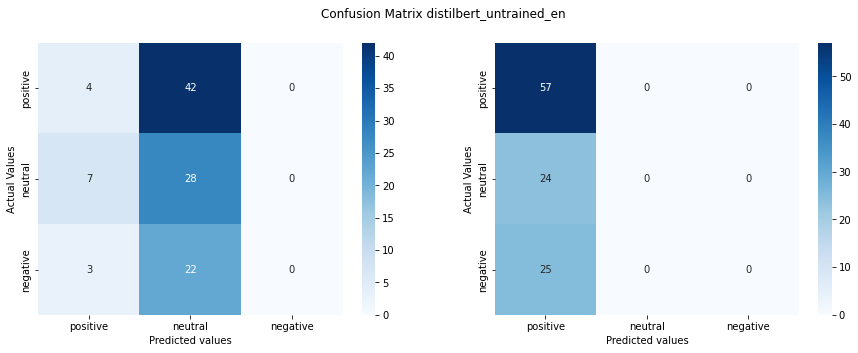

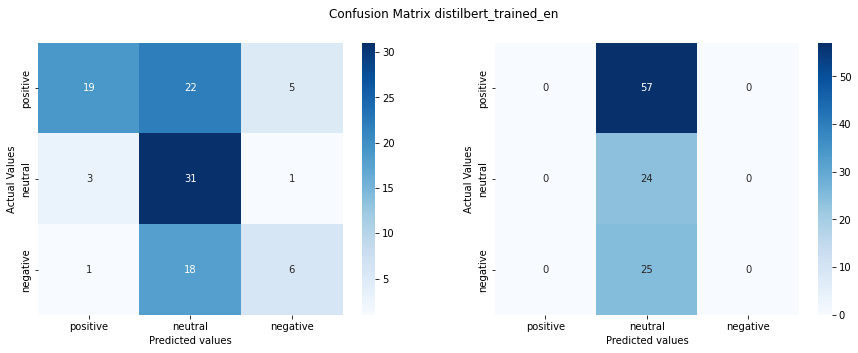

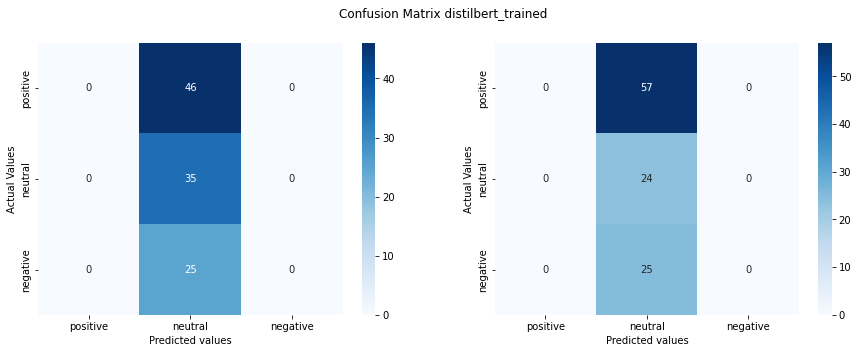

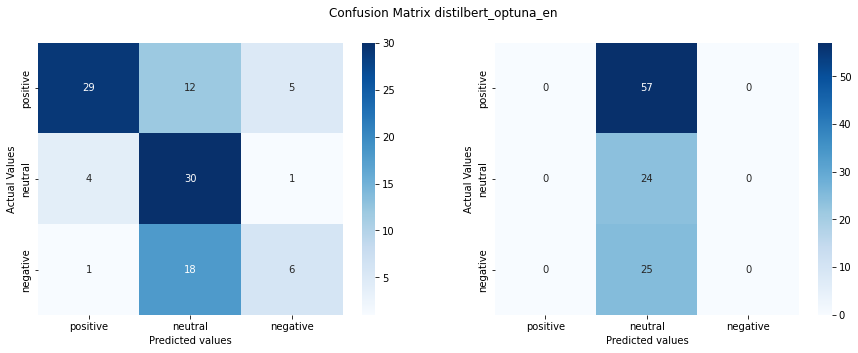

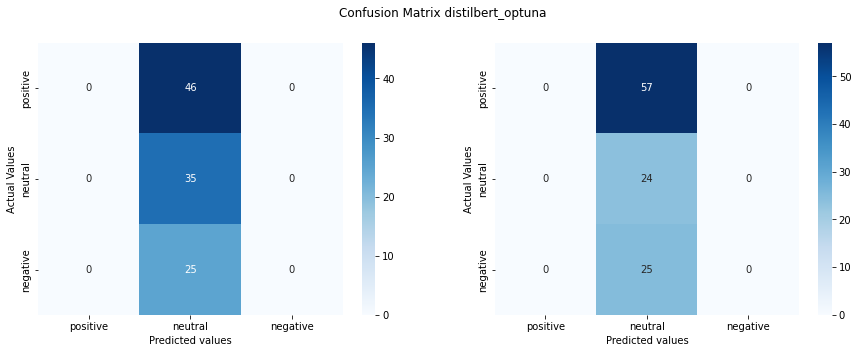

In [139]:
for x in ["distilbert_untrained_en", "distilbert_trained_en", "distilbert_trained", "distilbert_optuna_en",
          "distilbert_optuna"]:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Confusion Matrix {x}")
    sns.heatmap(cms[x][0], annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cms[x][1], annot=True, cmap='Blues', ax=axs[1])
    for ax in axs:
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual Values')
        ax.xaxis.set_ticklabels(['positive', 'neutral', 'negative'])
        ax.yaxis.set_ticklabels(['positive', 'neutral', 'negative'])
    fig.show()